# Part 3D: MNIST CNN with PyTorch

_Author: Suyog Garg_, _Dated: 2025/11/18_



This notebook implements a compact **PyTorch** CNN using `torchvision` datasets and a simple
training loop. It auto-detects **CUDA**, **MPS** (Apple Silicon), or **CPU**.


## Environment

In [1]:

import os, sys, time, json, pathlib, math
import numpy as np
import matplotlib.pyplot as plt
import torch, torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

print("Torch:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print("Device:", device)
if device.type == "cuda":
    torch.backends.cudnn.benchmark = True
try:
    torch.set_float32_matmul_precision("medium")
except Exception:
    pass


Torch: 2.9.1
Device: mps



## Dataset & preprocessing

We use **MNIST** (28×28 grayscale digits, 10 classes). Input is normalized to `[0, 1]`
and reshaped to `(N, 28, 28, 1)` for CNNs. Labels are integers `0..9`.

We use `torchvision.datasets.MNIST` and standard normalization.

In [2]:

tfm = transforms.Compose([transforms.ToTensor()])  # converts to [0,1] and adds channel dim
train_ds = datasets.MNIST(root="data", train=True, download=True, transform=tfm)
test_ds  = datasets.MNIST(root="data", train=False, download=True, transform=tfm)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=(device.type=="cuda"))
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, num_workers=2, pin_memory=(device.type=="cuda"))


100%|███████████████████████████████████████████████████| 9.91M/9.91M [00:03<00:00, 3.25MB/s]
100%|████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 147kB/s]
100%|███████████████████████████████████████████████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|███████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 1.63MB/s]


## Model + training loop

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,32,3), nn.ReLU(),
            nn.Conv2d(32,64,3), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(9216,128), nn.ReLU(),
            nn.Linear(128,10)
        )
    def forward(self, x):
        return self.net(x)

model = Net().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [4]:
def train_epoch():
    model.train()
    ls=0.0; n=0
    for x,y in train_loader:
        x = x.to(device, non_blocking=True); y = y.to(device, non_blocking=True)
        opt.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        opt.step()
        ls += float(loss.item()); n += 1
    return ls/max(n,1)

def evaluate():
    model.eval()
    correct=0; total=0; ls=0.0; n=0
    with torch.no_grad():
        for x,y in test_loader:
            x = x.to(device, non_blocking=True); y = y.to(device, non_blocking=True)
            logits = model(x)
            loss = loss_fn(logits, y)
            pred = logits.argmax(1)
            correct += int((pred==y).sum().item()); total += int(y.numel())
            ls += float(loss.item()); n += 1
    return ls/max(n,1), correct/total


In [5]:
EPOCHS=5
t0=time.perf_counter()
train_hist=[]; val_hist=[]
for epoch in range(EPOCHS):
    tl=train_epoch(); vl,va=evaluate()
    train_hist.append(tl); val_hist.append(vl)
    print(f"Epoch {epoch+1}/{EPOCHS} - loss {tl:.4f} - val_loss {vl:.4f} - val_acc {va:.4f}")
train_time=time.perf_counter()-t0
test_loss, test_acc = evaluate()
print("Test acc:", test_acc)

Epoch 1/5 - loss 0.2049 - val_loss 0.0550 - val_acc 0.9811
Epoch 2/5 - loss 0.0504 - val_loss 0.0358 - val_acc 0.9876
Epoch 3/5 - loss 0.0355 - val_loss 0.0297 - val_acc 0.9902
Epoch 4/5 - loss 0.0256 - val_loss 0.0320 - val_acc 0.9892
Epoch 5/5 - loss 0.0205 - val_loss 0.0303 - val_acc 0.9893
Test acc: 0.9893


## Curves

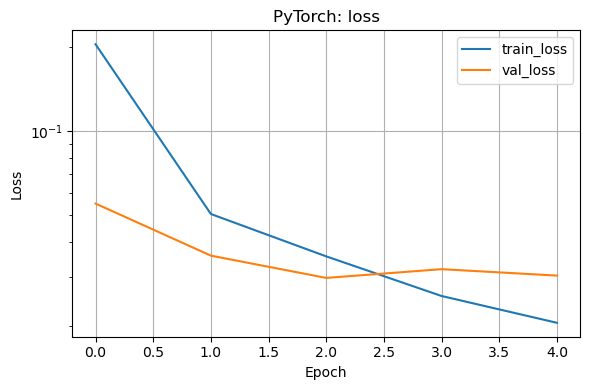

In [11]:

plt.figure(figsize=(6,4))
plt.plot(train_hist, label="train_loss")
plt.plot(val_hist, label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True); plt.title("PyTorch: loss")
plt.yscale('log')
plt.tight_layout()
plt.savefig("artifacts/pytorch_loss.png", dpi=150)
plt.show()


## Save metrics & model

In [7]:
# Utility: save artifacts (plots & metrics)
import os, json, pathlib, time
ART = pathlib.Path("artifacts")
ART.mkdir(exist_ok=True)

In [8]:
def save_metrics(name, **metrics):
    path = ART / f"{name}_metrics.json"
    with open(path, "w") as f:
        json.dump(metrics, f, indent=2)
    print("Saved:", path)

def effective_loc(*funcs):
    import inspect
    n = 0
    for f in funcs:
        try:
            src = inspect.getsource(f)
            for line in src.splitlines():
                s = line.strip()
                if s and not s.startswith("#"):
                    n += 1
        except Exception:
            pass
    return n

In [9]:
save_metrics("pytorch", framework="pytorch", test_accuracy=float(test_acc), test_loss=float(test_loss),
             train_time_sec=float(train_time), params=int(sum(p.numel() for p in model.parameters())),
             epochs=len(train_hist), device=str(device),
             effective_loc=int(effective_loc(Net, train_epoch, evaluate)))
torch.save(model.state_dict(), "artifacts/pytorch_mnist.pt")
print("Saved artifacts/ and metrics.")


Saved: artifacts/pytorch_metrics.json
Saved artifacts/ and metrics.
